# Preprocessing Overview — Human Pancreas (Baron)
#### Input dataset: dataset/human_pancreas_data.h5
This HDF5 contains X (raw counts), cell_name (cell IDs), gene_name (gene symbols), and Y (may be missing or incomplete). In this notebook we also compute labels, since predefined ground truth is not available: we run unsupervised clustering (on PCA/neighbor graph) and then assign cell-type names using canonical markers (e.g., endocrine: INS, GCG, SST, PPY, GHRL; exocrine/ductal/acinar: KRT19, MUC1, PRSS1, CPA1; endothelial/stellate/fibro/immune: PECAM1, RGS5, COL1A1, PTPRC). The inferred labels are stored in adata.obs['cell_type'] for downstream evaluation.

1. Imports & Data Loading
2. QC Filtering & Thresholds
3. Normalization & Log Transform
4. Highly Variable Genes (HVGs) + Forced Markers (retain key pancreatic markers even if not in top HVGs)
5. Dimensionality Reduction & Neighbors (PCA → kNN)
6. Unsupervised Clustering & Marker-Based Label Inference (Leiden/Louvain on kNN; map clusters to types via marker expression)
7. Cell Count
8. Save Preprocessed Object

Overview:
This notebook cleans the Human Pancreas data, normalizes counts, selects informative genes while preserving key pancreatic markers, derives cell-type labels via clustering + marker expression, and prepares a compact representation (PCA/UMAP). The result is a standardized .h5ad with inferred labels that serves as the reproducible preprocessing stage for comparing KMeans, DEC, and scDCC

## 1. Imports & Data Loading
This block sets up the libraries you’ll use, then loads the Baron human pancreas data from four donor files. For each gzipped CSV, it reads the counts table, sets the cell barcode as the index, selects only the gene expression columns (dropping metadata like assigned_cluster and pk), and builds an AnnData object per donor. It preserves any provided labels in obs['celltype_true'] and records the donor ID in obs['donor']. Finally, it concatenates all donor-level AnnData objects into a single dataset (aligning genes by name) using batch_key='donor', so downstream steps can account for donor effects if needed.

In [1]:
# -------- Imports and Setup --------
import scanpy as sc
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from scipy.optimize import linear_sum_assignment
import random
from itertools import combinations, product
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import anndata as ad
import pandas as pd

In [2]:
# --- List Baron (Human Pancreas) donor files and donor IDs ---
human_files = [
    "dataset/GSE84133_RAW/GSM2230757_human1_umifm_counts.csv.gz",
    "dataset/GSE84133_RAW/GSM2230758_human2_umifm_counts.csv.gz",
    "dataset/GSE84133_RAW/GSM2230759_human3_umifm_counts.csv.gz",
    "dataset/GSE84133_RAW/GSM2230760_human4_umifm_counts.csv.gz"
]
donor_names = ["human1", "human2", "human3", "human4"]

adatas = []
for file, donor in zip(human_files, donor_names):
    # Read counts table (pandas handles .gz transparently)
    df = pd.read_csv(file)
    # Use the per-cell barcode as the index
    df = df.set_index('barcode')
    # Expression columns = all columns except known metadata columns
    gene_cols = df.columns.difference(['Unnamed: 0', 'assigned_cluster', 'pk'])
    # Build an AnnData with cells×genes counts
    adata = sc.AnnData(df[gene_cols])
    adata.obs['celltype_true'] = df['assigned_cluster']
    adata.obs['donor'] = donor
    adatas.append(adata)

# Concatenate donors into one AnnData; store donor in .obs['donor'] via batch_key
# Scanpy aligns genes by name across objects, handling differing gene orders
adata = adatas[0].concatenate(adatas[1:], batch_key='donor', batch_categories=donor_names)

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipython-input-627127804.py:26: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. S

In [3]:
print("Shape after loading:", adata.shape)

Shape after loading: (8569, 20124)


## 2. QC Filtering & Thresholds
This section is performing quality control on the single-cell RNA-seq dataset:

* Filters low-quality cells (low gene counts, high mitochondrial content).
* Removes rare genes detected in too few cells.
* Uses QC plots to visually assess filtering thresholds.
* Removes outliers to ensure only high-quality cells remain for analysis.

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


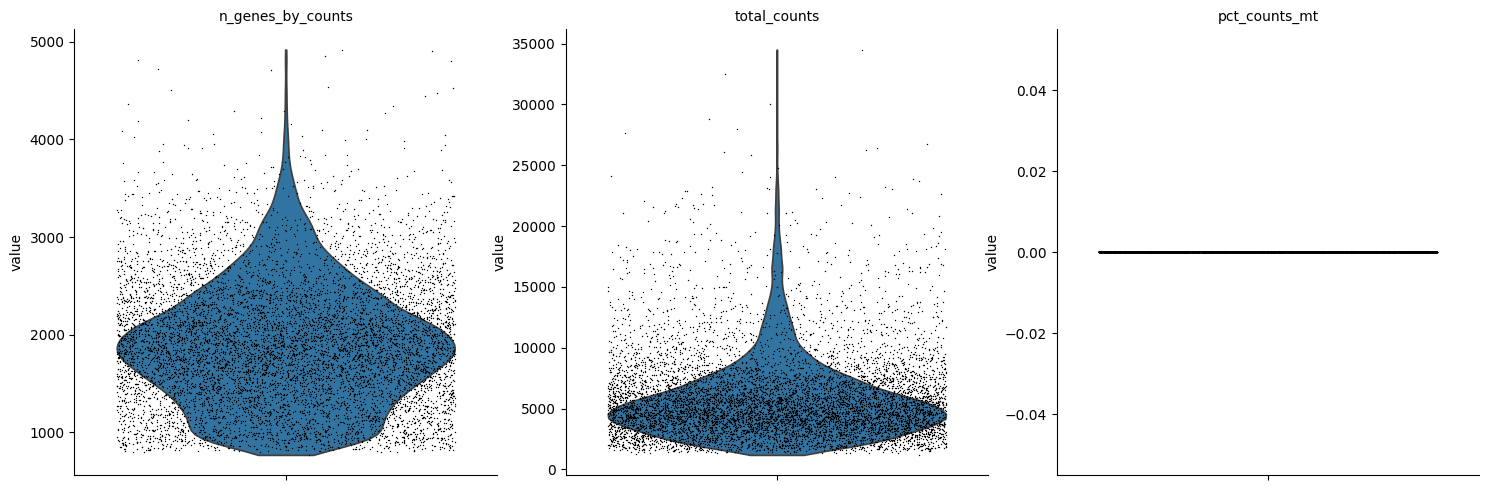

In [4]:
# --- Basic filtering ---
# Keep cells that have at least 200 detected genes
sc.pp.filter_cells(adata, min_genes=200)

# Keep genes that are detected in at least 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# --- Identify mitochondrial genes ---
# Create a boolean mask for mitochondrial genes (gene names start with 'MT-')
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')

# Calculate quality control (QC) metrics
# qc_vars=['mt'] ensures mitochondrial gene percentages are included
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# --- Visualize QC metrics ---
# Violin plots showing:
# - Number of genes detected per cell (n_genes_by_counts)
# - Total counts per cell (total_counts)
# - Percentage of mitochondrial counts (pct_counts_mt)
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)
plt.show()

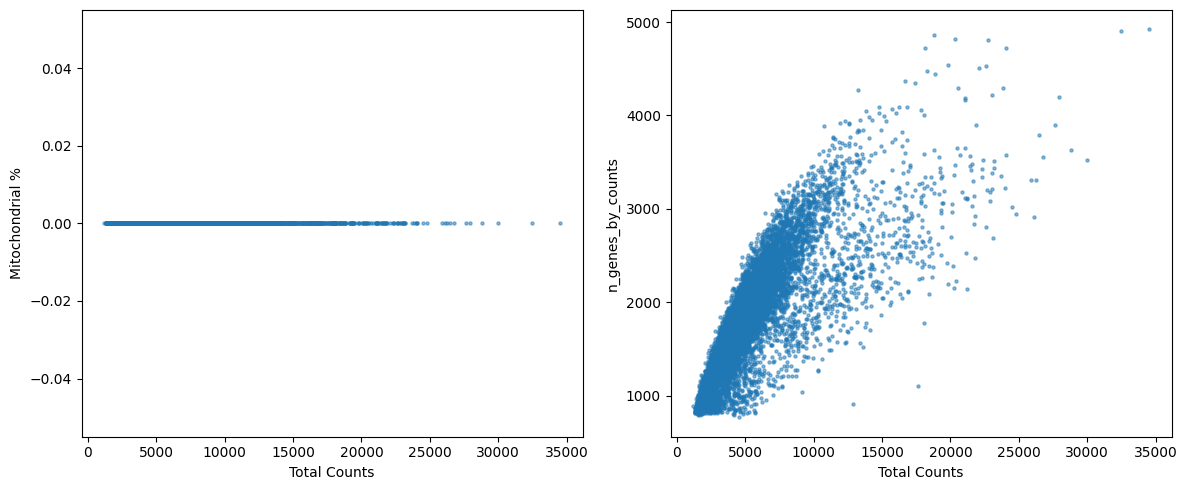

In [5]:
# Scatter plots to explore relationships between QC metrics
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Total counts vs mitochondrial percentage
axs[0].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'], s=5, alpha=0.5)
axs[0].set_xlabel('Total Counts'); axs[0].set_ylabel('Mitochondrial %')

# Total counts vs number of genes detected
axs[1].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], s=5, alpha=0.5)
axs[1].set_xlabel('Total Counts'); axs[1].set_ylabel('n_genes_by_counts')
plt.tight_layout(); plt.show()

# Determine cutoffs for unusually high counts or genes (remove outliers)
gene_cutoff = np.percentile(adata.obs['n_genes_by_counts'], 98)
count_cutoff = np.percentile(adata.obs['total_counts'], 98)

# Apply cutoffs
adata = adata[adata.obs['n_genes_by_counts'] < gene_cutoff, :]
adata = adata[adata.obs['total_counts'] < count_cutoff, :]

/tmp/ipython-input-1784738465.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()


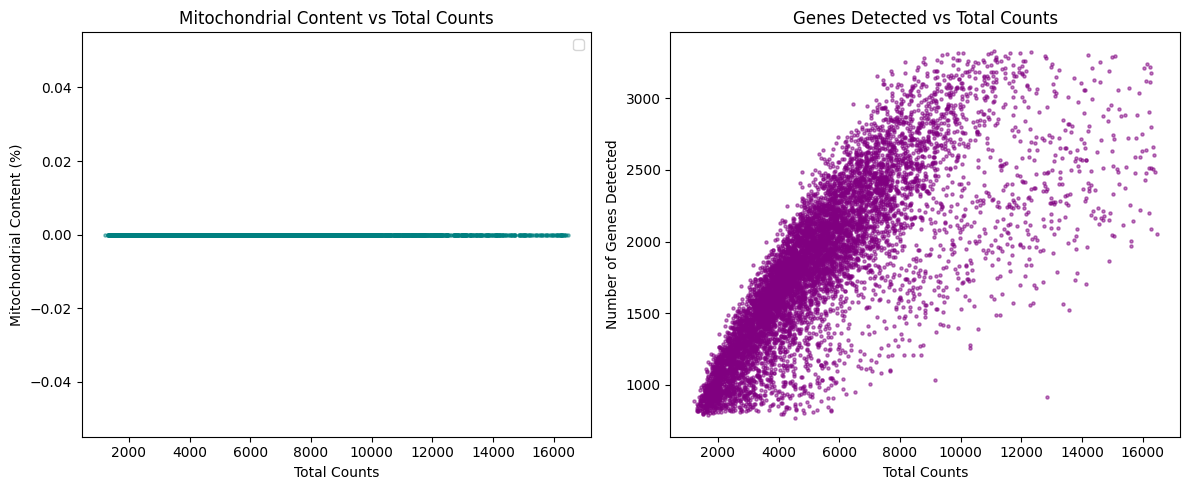

In [6]:
# --- Visualize filtered dataset ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Mitochondrial content vs total counts
axs[0].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'], s=5, alpha=0.5, color='teal')
axs[0].set_xlabel('Total Counts')
axs[0].set_ylabel('Mitochondrial Content (%)')
axs[0].set_title('Mitochondrial Content vs Total Counts')
axs[0].legend()

# Number of genes detected vs total counts
axs[1].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], s=5, alpha=0.5, color='purple')
axs[1].set_xlabel('Total Counts')
axs[1].set_ylabel('Number of Genes Detected')
axs[1].set_title('Genes Detected vs Total Counts')

plt.tight_layout()
plt.show()

## 3. Normalization & Log Transform:
This step scales and stabilizes the data before feature selection and clustering. Without this, cells with more reads or extremely high gene counts could dominate the analysis.

In [7]:
# --- Normalize the data ---
# Normalize total counts per cell so that each cell has the same total count (target_sum = 10,000)
# This ensures comparability between cells by removing sequencing depth bias
sc.pp.normalize_total(adata, target_sum=1e4)

# --- Log-transform the data ---
# Apply log(x + 1) transformation to reduce the impact of highly expressed genes
# This makes the data more normally distributed and suitable for downstream analysis
sc.pp.log1p(adata)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## 4. Highly Variable Genes (HVGs) + Forced Markers (retain key pancreatic markers even if not in top HVGs)
This block picks the most informative genes and prepares the pancreas data for downstream analysis. First, it selects the top 1,500 highly variable genes (HVGs) using the Seurat method. Then it force-includes key pancreatic markers (islet hormones, ductal/acinar, stromal, endothelial, immune, mast cell markers) so they’re kept even if they’re not among the top HVGs—ensuring biologically important signals aren’t dropped. The code builds a combined mask (HVGs + markers), subsets adata to those genes, saves a raw copy for reference, and finally normalizes per cell (to 10k counts) and log-transforms the subset. The result (adata_hvg) is a compact, biologically informed feature set ready for PCA/UMAP and clustering.

In [8]:
# --- Identify Highly Variable Genes (HVGs) ---
# Select the top 1,500 HVGs using the Seurat method.
# HVGs capture most of the biological signal useful for clustering.
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=1500, subset=False)

# --- Pancreas-specific markers to force-include ---
# Endocrine (islet) hormones: alpha/beta/delta/PP/epsilon
#   GCG (alpha), INS (beta), SST (delta), PPY (PP), GHRL (epsilon)
# Epithelial/ductal/acinar / stromal / endothelial / immune / mast
#   KRT19 (ductal), CPA1 (acinar), PDGFRB (stromal/pericyte),
#   VWF/PECAM1/CD34 (endothelial), CD163/CD68/IGG (myeloid/B),
#   CD3D/CD3E/CD8A (T cells), TPSAB1/KIT/CPA3 (mast)
force_markers = [
    "GCG", "INS", "SST", "PPY", "GHRL",
    "KRT19", "CPA1", "PDGFRB",
    "VWF", "PECAM1", "CD34",
    "CD163", "CD68", "IGG",
    "CD3D", "CD3E", "CD8A",
    "TPSAB1", "KIT", "CPA3"
]

# --- Ensure markers are kept even if not in top HVGs ---
hvg_mask = adata.var['highly_variable'].copy()
for g in force_markers:
    if g in adata.var_names: # only if gene exists in this dataset
        hvg_mask[adata.var_names.get_loc(g)] = True # flip mask to keep it

# --- Subset to HVGs + forced markers and preserve a raw view ---
adata_hvg = adata[:, hvg_mask].copy()
adata_hvg.raw = adata_hvg.copy() # store unnormalized counts for reference

# --- Re-normalize and log-transform after HVG selection ---
# Ensures the reduced dataset is scaled and ready for analysis
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)

/tmp/ipython-input-3430714223.py:26: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  hvg_mask[adata.var_names.get_loc(g)] = True # flip mask to keep it
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## 5. Dimensionality Reduction & Neighbors (PCA → kNN)
This section reduces the dataset’s dimensionality using PCA, builds a nearest neighbors graph from the reduced space, and then applies UMAP to project the cells into 2D for easier visualization of clusters and relationships between cell types.

In [9]:
# --- Dimensionality reduction (PCA) ---
# Computes principal components (default ~50 PCs in Scanpy) on adata_hvg.X
# Captures major sources of variation and denoises the data.
sc.pp.pca(adata_hvg)

# --- Graph construction (kNN on PCs) ---
# Builds the k-nearest neighbors graph using the PCA embedding.
# Defaults: n_neighbors=15, uses all available PCs unless specified.
sc.pp.neighbors(adata_hvg)

# --- 2D embedding for visualization ---
# Projects cells to 2D with UMAP for visual inspection of cluster structure.
sc.tl.umap(adata_hvg)

# --- Unsupervised clustering (Leiden) ---
# Partitions the kNN graph into communities; 'resolution' controls cluster granularity.
# Results are stored in adata_hvg.obs['clusters'].
sc.tl.leiden(adata_hvg, resolution=1.0, key_added='clusters')

/tmp/ipython-input-2395550264.py:18: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hvg, resolution=1.0, key_added='clusters')


## 6. Unsupervised Clustering & Marker-Based Label Inference (Leiden/Louvain on kNN; map clusters to types via marker expression)
This block assigns cell-type names to clusters using marker genes.
For each Leiden cluster, it computes the average expression of the marker list for every candidate cell type (Alpha, Beta, Ductal, etc.), chooses the cell type with the highest mean marker signal, and writes that label to adata.obs['cell_type']. It only scores markers that actually exist in adata.var_names, so missing genes are skipped. The function runs on the HVG view (adata_hvg) and provides quick, interpretable marker-based annotations for the unsupervised clusters.

In [10]:
# ---- Marker-based annotation ----
# Map broad pancreatic cell types to a small set of canonical marker genes.
marker_dict = {
    "Alpha": ["GCG"],
    "Beta": ["INS"],
    "Delta": ["SST"],
    "Gamma": ["PPY"],
    "Epsilon": ["GHRL"],
    "Ductal": ["KRT19"],
    "Acinar": ["CPA1"],
    "Stellate": ["PDGFRB"],
    "Vascular": ["VWF", "PECAM1", "CD34"],
    "Macrophage": ["CD163", "CD68", "IgG"],
    "T-cell": ["CD3", "CD8"],
    "Mast": ["TPSAB1", "KIT", "CPA3"]
}

def annotate_by_marker(adata, marker_dict, cluster_key='clusters'):
    clusters = adata.obs[cluster_key].unique()
    cluster_annotation = {}
    for cluster in clusters:
        # Boolean mask for cells in this cluster
        cells = adata.obs[cluster_key] == cluster

        # Compute mean marker expression per candidate cell type
        means = {}
        for celltype, genes in marker_dict.items():
            expr = []
            for gene in genes:
                if gene in adata.var_names: # only score markers present in the dataset
                    expr.append(adata[cells, gene].X.mean()) # average expression of this marker within the cluster
            means[celltype] = np.mean(expr) if expr else 0 # average across markers for this cell type

        # Pick the cell type with the highest mean marker signal
        cluster_annotation[cluster] = max(means, key=means.get)

    # Map per-cluster annotations back to per-cell labels
    adata.obs['cell_type'] = adata.obs[cluster_key].map(cluster_annotation)
    return adata

# Apply marker-based annotation on the HVG view using Leiden clusters
adata_hvg = annotate_by_marker(adata_hvg, marker_dict, cluster_key='clusters')

## 7. Cell Count
This prints a clean summary of how many cells belong to each annotated cell_type in the preprocessed HVG subset (adata_hvg).

In [11]:
# Display the count of cells for each annotated cell type
print("\n--- Annotated Cell Type Distribution ---")
print(adata_hvg.obs['cell_type'].value_counts().to_string())


--- Annotated Cell Type Distribution ---
cell_type
Beta        3205
Alpha       2253
Ductal       855
Acinar       817
Delta        613
Stellate     281
Gamma        260


## 8. Save Preprocessed Object

In [12]:
adata_hvg.write("processed_dataset/baron_pancreas_preprocessed.h5ad")